# Whatami

I am a simple experiment on using actor-critic agent setup for MountainCar problem.
Being policy-based method, actor-critic has much better convergence properties that q-learning from the other notebook.

## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
obs = env.step(0)[0]
action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)
print(obs)

[2016-12-19 20:34:09,470] Making new env: MountainCar-v0


[-0.45757839 -0.00150297]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


In [6]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.softmax,
                   name="q-evaluator layer")


V_layer = DenseLayer(dense1, 1, nonlinearity=None,name="state values")

In [7]:


import theano
epsilon = theano.shared(np.float32(0),allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1.-epsilon)*p + epsilon/env.action_space.n)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [8]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b,
 state values.W,
 state values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [10]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2016-12-19 20:34:10,303] Making new env: MountainCar-v0
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
[2016-12-19 20:34:11,544] install mkl with `conda install mkl-service`: No module named mkl


In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'left' 'left' 'right' 'left' 'left' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 13.9 ms


In [12]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/agent/mdp_agent.py:142: UserWarning: optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  warn("optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.")


In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import a2c_n_step

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = a2c_n_step.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       gamma_or_gammas=0.99,
                                                       n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
from theano import tensor as T
reg_entropy = T.mean((1./policy_seq))
loss += 0.01*reg_entropy

In [16]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [17]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


# Demo run

In [18]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2016-12-19 20:34:20,131] Making new env: MountainCar-v0
[2016-12-19 20:34:20,136] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:34:20,218] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


Episode finished after 200 timesteps with reward=-200.0


In [19]:
from IPython.display import HTML

#video_path="./records/openaigym.video.0.7346.video000000.mp4"

#HTML("""
#<video width="640" height="480" controls>
#  <source src="{}" type="video/mp4">
#</video>
#""".format(video_path))


# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [21]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,)


100%|██████████| 1000/1000 [00:01<00:00, 627.22it/s]


In [22]:

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,)
    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
        
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i\tloss ma=%.5f"%(epoch_counter,
                                                         epsilon.get_value(),
                                                         pool_mean_reward,
                                                         pool_size,
                                                         loss))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.05)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 102/10000 [00:07<12:02, 13.69it/s]

iter=100	epsilon=0.000	reward/step=-0.99997	pool_size=2001	loss ma=0.72584


  2%|▏         | 202/10000 [00:14<13:23, 12.20it/s]

iter=200	epsilon=0.000	reward/step=-0.99996	pool_size=3001	loss ma=0.50522


  3%|▎         | 302/10000 [00:22<11:53, 13.59it/s]

iter=300	epsilon=0.000	reward/step=-0.99996	pool_size=4001	loss ma=0.37107


  4%|▍         | 402/10000 [00:29<11:45, 13.61it/s]

iter=400	epsilon=0.000	reward/step=-0.99991	pool_size=5001	loss ma=0.19284


  5%|▍         | 498/10000 [00:36<11:41, 13.55it/s][2016-12-19 20:34:58,877] Making new env: MountainCar-v0
[2016-12-19 20:34:58,880] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.000	reward/step=-0.99988	pool_size=6001	loss ma=0.22228


[2016-12-19 20:34:59,165] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
  5%|▌         | 502/10000 [00:37<16:30,  9.59it/s]

Current score(mean over 10) = -200.000


  6%|▌         | 602/10000 [00:44<11:34, 13.52it/s]

iter=600	epsilon=0.050	reward/step=-0.99979	pool_size=7001	loss ma=0.55743


  7%|▋         | 702/10000 [00:52<12:45, 12.14it/s]

iter=700	epsilon=0.050	reward/step=-0.99959	pool_size=8001	loss ma=0.99554


  8%|▊         | 802/10000 [01:00<13:27, 11.40it/s]

iter=800	epsilon=0.050	reward/step=-0.99935	pool_size=9001	loss ma=1.19025


  9%|▉         | 902/10000 [01:09<12:05, 12.55it/s]

iter=900	epsilon=0.050	reward/step=-0.99913	pool_size=10000	loss ma=0.84936


 10%|▉         | 998/10000 [01:16<11:40, 12.85it/s][2016-12-19 20:35:39,167] Making new env: MountainCar-v0
[2016-12-19 20:35:39,171] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:35:39,344] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 10%|█         | 1000/10000 [01:17<15:36,  9.61it/s]

iter=1000	epsilon=0.050	reward/step=-0.99883	pool_size=10000	loss ma=0.69412
Current score(mean over 10) = -155.600


 11%|█         | 1100/10000 [01:25<13:00, 11.40it/s]

iter=1100	epsilon=0.050	reward/step=-0.99851	pool_size=10000	loss ma=0.39390


 12%|█▏        | 1202/10000 [01:34<12:17, 11.93it/s]

iter=1200	epsilon=0.050	reward/step=-0.99821	pool_size=10000	loss ma=0.26830


 13%|█▎        | 1302/10000 [01:42<11:53, 12.19it/s]

iter=1300	epsilon=0.050	reward/step=-0.99788	pool_size=10000	loss ma=0.24244


 14%|█▍        | 1400/10000 [01:50<12:17, 11.66it/s]

iter=1400	epsilon=0.050	reward/step=-0.99759	pool_size=10000	loss ma=0.17335


 15%|█▍        | 1498/10000 [01:58<11:03, 12.81it/s][2016-12-19 20:36:20,847] Making new env: MountainCar-v0
[2016-12-19 20:36:20,849] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:36:21,015] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 15%|█▌        | 1500/10000 [01:58<14:40,  9.65it/s]

iter=1500	epsilon=0.050	reward/step=-0.99729	pool_size=10000	loss ma=0.15550
Current score(mean over 10) = -149.200


 16%|█▌        | 1602/10000 [02:06<11:00, 12.71it/s]

iter=1600	epsilon=0.050	reward/step=-0.99706	pool_size=10000	loss ma=0.17565


 17%|█▋        | 1702/10000 [02:14<10:50, 12.76it/s]

iter=1700	epsilon=0.050	reward/step=-0.99691	pool_size=10000	loss ma=0.20622


 18%|█▊        | 1802/10000 [02:22<10:42, 12.76it/s]

iter=1800	epsilon=0.050	reward/step=-0.99685	pool_size=10000	loss ma=0.19754


 19%|█▉        | 1902/10000 [02:30<10:36, 12.73it/s]

iter=1900	epsilon=0.050	reward/step=-0.99682	pool_size=10000	loss ma=0.18714


 20%|█▉        | 1998/10000 [02:38<10:36, 12.56it/s][2016-12-19 20:37:00,449] Making new env: MountainCar-v0
[2016-12-19 20:37:00,452] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:37:00,629] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 20%|██        | 2000/10000 [02:38<14:13,  9.37it/s]

iter=2000	epsilon=0.050	reward/step=-0.99682	pool_size=10000	loss ma=0.16843
Current score(mean over 10) = -151.500


 21%|██        | 2102/10000 [02:47<11:44, 11.22it/s]

iter=2100	epsilon=0.050	reward/step=-0.99682	pool_size=10000	loss ma=0.17883


 22%|██▏       | 2202/10000 [02:55<11:04, 11.73it/s]

iter=2200	epsilon=0.050	reward/step=-0.99682	pool_size=10000	loss ma=0.16606


 23%|██▎       | 2302/10000 [03:04<10:41, 12.00it/s]

iter=2300	epsilon=0.050	reward/step=-0.99683	pool_size=10000	loss ma=0.17313


 24%|██▍       | 2402/10000 [03:12<10:08, 12.48it/s]

iter=2400	epsilon=0.050	reward/step=-0.99685	pool_size=10000	loss ma=0.16402


 25%|██▍       | 2498/10000 [03:19<09:56, 12.57it/s][2016-12-19 20:37:42,157] Making new env: MountainCar-v0
[2016-12-19 20:37:42,160] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:37:42,331] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 25%|██▌       | 2500/10000 [03:20<13:16,  9.42it/s]

iter=2500	epsilon=0.050	reward/step=-0.99687	pool_size=10000	loss ma=0.15221
Current score(mean over 10) = -146.800


 26%|██▌       | 2602/10000 [03:28<10:14, 12.05it/s]

iter=2600	epsilon=0.050	reward/step=-0.99685	pool_size=10000	loss ma=0.15494


 27%|██▋       | 2702/10000 [03:37<10:20, 11.77it/s]

iter=2700	epsilon=0.050	reward/step=-0.99685	pool_size=10000	loss ma=0.16668


 28%|██▊       | 2801/10000 [03:46<09:58, 12.03it/s]

iter=2800	epsilon=0.050	reward/step=-0.99683	pool_size=10000	loss ma=0.18580


 29%|██▉       | 2901/10000 [03:54<09:33, 12.38it/s]

iter=2900	epsilon=0.050	reward/step=-0.99681	pool_size=10000	loss ma=0.18858


 30%|██▉       | 2999/10000 [04:02<10:11, 11.45it/s][2016-12-19 20:38:24,421] Making new env: MountainCar-v0
[2016-12-19 20:38:24,424] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:38:24,593] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=3000	epsilon=0.050	reward/step=-0.99677	pool_size=10000	loss ma=0.21530
Current score(mean over 10) = -133.000


 31%|███       | 3101/10000 [04:11<10:05, 11.39it/s]

iter=3100	epsilon=0.050	reward/step=-0.99673	pool_size=10000	loss ma=0.22996


 32%|███▏      | 3202/10000 [04:20<11:18, 10.02it/s]

iter=3200	epsilon=0.050	reward/step=-0.99669	pool_size=10000	loss ma=0.23401


 33%|███▎      | 3301/10000 [04:30<09:51, 11.33it/s]

iter=3300	epsilon=0.050	reward/step=-0.99666	pool_size=10000	loss ma=0.21854


 34%|███▍      | 3401/10000 [04:40<11:09,  9.86it/s]

iter=3400	epsilon=0.050	reward/step=-0.99662	pool_size=10000	loss ma=0.23033


 35%|███▍      | 3499/10000 [04:48<09:14, 11.72it/s][2016-12-19 20:39:11,014] Making new env: MountainCar-v0
[2016-12-19 20:39:11,017] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:39:11,186] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=3500	epsilon=0.050	reward/step=-0.99658	pool_size=10000	loss ma=0.23797
Current score(mean over 10) = -135.500


 36%|███▌      | 3601/10000 [04:58<10:24, 10.24it/s]

iter=3600	epsilon=0.050	reward/step=-0.99657	pool_size=10000	loss ma=0.25341


 37%|███▋      | 3701/10000 [05:08<10:03, 10.44it/s]

iter=3700	epsilon=0.050	reward/step=-0.99655	pool_size=10000	loss ma=0.24412


 38%|███▊      | 3802/10000 [05:17<10:08, 10.18it/s]

iter=3800	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.24729


 39%|███▉      | 3901/10000 [05:27<10:16,  9.89it/s]

iter=3900	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.27386


 40%|███▉      | 3999/10000 [05:35<08:14, 12.14it/s][2016-12-19 20:39:57,809] Making new env: MountainCar-v0
[2016-12-19 20:39:57,812] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:39:57,954] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=4000	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.28297
Current score(mean over 10) = -126.500


 41%|████      | 4101/10000 [05:44<07:54, 12.43it/s]

iter=4100	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.27523


 42%|████▏     | 4201/10000 [05:52<07:55, 12.19it/s]

iter=4200	epsilon=0.050	reward/step=-0.99653	pool_size=10000	loss ma=0.28236


 43%|████▎     | 4301/10000 [06:00<07:42, 12.32it/s]

iter=4300	epsilon=0.050	reward/step=-0.99652	pool_size=10000	loss ma=0.27331


 44%|████▍     | 4401/10000 [06:09<08:47, 10.62it/s]

iter=4400	epsilon=0.050	reward/step=-0.99650	pool_size=10000	loss ma=0.27940


 45%|████▍     | 4499/10000 [06:17<07:36, 12.05it/s][2016-12-19 20:40:39,308] Making new env: MountainCar-v0
[2016-12-19 20:40:39,462] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=4500	epsilon=0.050	reward/step=-0.99649	pool_size=10000	loss ma=0.33166
Current score(mean over 10) = -131.100


 46%|████▌     | 4601/10000 [06:25<07:30, 11.98it/s]

iter=4600	epsilon=0.050	reward/step=-0.99647	pool_size=10000	loss ma=0.29079


 47%|████▋     | 4701/10000 [06:35<08:47, 10.05it/s]

iter=4700	epsilon=0.050	reward/step=-0.99647	pool_size=10000	loss ma=0.35566


 48%|████▊     | 4801/10000 [06:43<07:12, 12.01it/s]

iter=4800	epsilon=0.050	reward/step=-0.99647	pool_size=10000	loss ma=0.34532


 49%|████▉     | 4901/10000 [06:51<07:04, 12.01it/s]

iter=4900	epsilon=0.050	reward/step=-0.99647	pool_size=10000	loss ma=0.34762


 50%|████▉     | 4999/10000 [06:59<06:54, 12.07it/s][2016-12-19 20:41:21,995] Making new env: MountainCar-v0
[2016-12-19 20:41:21,999] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-12-19 20:41:22,156] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=5000	epsilon=0.050	reward/step=-0.99646	pool_size=10000	loss ma=0.35740
Current score(mean over 10) = -138.700


 51%|█████     | 5101/10000 [07:08<06:48, 11.98it/s]

iter=5100	epsilon=0.050	reward/step=-0.99645	pool_size=10000	loss ma=0.39005


 52%|█████▏    | 5201/10000 [07:16<06:41, 11.96it/s]

iter=5200	epsilon=0.050	reward/step=-0.99645	pool_size=10000	loss ma=0.39790


 53%|█████▎    | 5301/10000 [07:25<06:32, 11.97it/s]

iter=5300	epsilon=0.050	reward/step=-0.99648	pool_size=10000	loss ma=0.38057


 54%|█████▍    | 5401/10000 [07:33<07:31, 10.19it/s]

iter=5400	epsilon=0.050	reward/step=-0.99649	pool_size=10000	loss ma=0.39558


 55%|█████▍    | 5498/10000 [07:42<07:20, 10.21it/s][2016-12-19 20:42:04,999] Making new env: MountainCar-v0
[2016-12-19 20:42:05,002] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	epsilon=0.050	reward/step=-0.99648	pool_size=10000	loss ma=0.40185


[2016-12-19 20:42:05,237] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 55%|█████▌    | 5500/10000 [07:43<09:57,  7.53it/s]

Current score(mean over 10) = -137.800


 56%|█████▌    | 5601/10000 [07:52<06:48, 10.76it/s]

iter=5600	epsilon=0.050	reward/step=-0.99648	pool_size=10000	loss ma=0.38026


 57%|█████▋    | 5701/10000 [08:01<06:12, 11.54it/s]

iter=5700	epsilon=0.050	reward/step=-0.99645	pool_size=10000	loss ma=0.41058


 58%|█████▊    | 5801/10000 [08:09<05:50, 11.97it/s]

iter=5800	epsilon=0.050	reward/step=-0.99643	pool_size=10000	loss ma=0.38265


 59%|█████▉    | 5901/10000 [08:18<05:46, 11.82it/s]

iter=5900	epsilon=0.050	reward/step=-0.99640	pool_size=10000	loss ma=0.38378


 60%|█████▉    | 5999/10000 [08:26<05:34, 11.97it/s][2016-12-19 20:42:48,422] Making new env: MountainCar-v0
[2016-12-19 20:42:48,426] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:42:48,572] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=6000	epsilon=0.050	reward/step=-0.99639	pool_size=10000	loss ma=0.41561
Current score(mean over 10) = -127.400


 61%|██████    | 6101/10000 [08:34<05:27, 11.91it/s]

iter=6100	epsilon=0.050	reward/step=-0.99639	pool_size=10000	loss ma=0.42273


 62%|██████▏   | 6201/10000 [08:43<05:50, 10.83it/s]

iter=6200	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.46644


 63%|██████▎   | 6302/10000 [08:53<05:17, 11.65it/s]

iter=6300	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.47797


 64%|██████▍   | 6401/10000 [09:01<06:49,  8.79it/s]

iter=6400	epsilon=0.050	reward/step=-0.99633	pool_size=10000	loss ma=0.48408


 65%|██████▍   | 6499/10000 [09:10<04:53, 11.91it/s][2016-12-19 20:43:32,319] Making new env: MountainCar-v0
[2016-12-19 20:43:32,322] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:43:32,463] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=6500	epsilon=0.050	reward/step=-0.99633	pool_size=10000	loss ma=0.49944
Current score(mean over 10) = -120.300


 66%|██████▌   | 6601/10000 [09:18<05:12, 10.86it/s]

iter=6600	epsilon=0.050	reward/step=-0.99634	pool_size=10000	loss ma=0.49282


 67%|██████▋   | 6701/10000 [09:28<04:35, 11.99it/s]

iter=6700	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.49860


 68%|██████▊   | 6801/10000 [09:38<05:28,  9.73it/s]

iter=6800	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.53625


 69%|██████▉   | 6902/10000 [09:48<05:25,  9.51it/s]

iter=6900	epsilon=0.050	reward/step=-0.99637	pool_size=10000	loss ma=0.50585


 70%|██████▉   | 6998/10000 [09:57<04:57, 10.10it/s][2016-12-19 20:44:20,085] Making new env: MountainCar-v0
[2016-12-19 20:44:20,088] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:44:20,239] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 70%|███████   | 7000/10000 [09:58<06:15,  8.00it/s]

iter=7000	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.50084
Current score(mean over 10) = -119.400


 71%|███████   | 7102/10000 [10:08<05:00,  9.63it/s]

iter=7100	epsilon=0.050	reward/step=-0.99638	pool_size=10000	loss ma=0.55332


 72%|███████▏  | 7201/10000 [10:17<04:07, 11.33it/s]

iter=7200	epsilon=0.050	reward/step=-0.99639	pool_size=10000	loss ma=0.50736


 73%|███████▎  | 7301/10000 [10:27<04:37,  9.72it/s]

iter=7300	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.52003


 74%|███████▍  | 7401/10000 [10:38<05:04,  8.55it/s]

iter=7400	epsilon=0.050	reward/step=-0.99637	pool_size=10000	loss ma=0.52012


 75%|███████▍  | 7499/10000 [10:48<03:57, 10.53it/s][2016-12-19 20:45:10,975] Making new env: MountainCar-v0
[2016-12-19 20:45:10,979] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:45:11,119] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')


iter=7500	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.55083
Current score(mean over 10) = -123.600


 76%|███████▌  | 7601/10000 [10:59<04:25,  9.05it/s]

iter=7600	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.54217


 77%|███████▋  | 7702/10000 [11:09<04:16,  8.97it/s]

iter=7700	epsilon=0.050	reward/step=-0.99632	pool_size=10000	loss ma=0.53188


 78%|███████▊  | 7801/10000 [11:19<03:44,  9.78it/s]

iter=7800	epsilon=0.050	reward/step=-0.99632	pool_size=10000	loss ma=0.56036


 79%|███████▉  | 7901/10000 [11:29<03:33,  9.82it/s]

iter=7900	epsilon=0.050	reward/step=-0.99631	pool_size=10000	loss ma=0.51693


 80%|███████▉  | 7999/10000 [11:39<03:33,  9.35it/s][2016-12-19 20:46:02,094] Making new env: MountainCar-v0
[2016-12-19 20:46:02,097] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:46:02,238] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 80%|████████  | 8000/10000 [11:40<04:53,  6.81it/s]

iter=8000	epsilon=0.050	reward/step=-0.99630	pool_size=10000	loss ma=0.53197
Current score(mean over 10) = -109.300


 81%|████████  | 8101/10000 [11:50<03:04, 10.31it/s]

iter=8100	epsilon=0.050	reward/step=-0.99629	pool_size=10000	loss ma=0.57134


 82%|████████▏ | 8202/10000 [12:00<02:53, 10.35it/s]

iter=8200	epsilon=0.050	reward/step=-0.99629	pool_size=10000	loss ma=0.58440


 83%|████████▎ | 8301/10000 [12:10<03:02,  9.33it/s]

iter=8300	epsilon=0.050	reward/step=-0.99631	pool_size=10000	loss ma=0.59126


 84%|████████▍ | 8402/10000 [12:19<02:18, 11.50it/s]

iter=8400	epsilon=0.050	reward/step=-0.99634	pool_size=10000	loss ma=0.62958


 85%|████████▍ | 8498/10000 [12:28<02:30,  9.95it/s][2016-12-19 20:46:50,588] Making new env: MountainCar-v0
[2016-12-19 20:46:50,593] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:46:50,777] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 85%|████████▌ | 8500/10000 [12:28<03:13,  7.77it/s]

iter=8500	epsilon=0.050	reward/step=-0.99634	pool_size=10000	loss ma=0.65528
Current score(mean over 10) = -117.500


 86%|████████▌ | 8602/10000 [12:38<02:05, 11.11it/s]

iter=8600	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.64135


 87%|████████▋ | 8701/10000 [12:48<02:12,  9.83it/s]

iter=8700	epsilon=0.050	reward/step=-0.99638	pool_size=10000	loss ma=0.59861


 88%|████████▊ | 8801/10000 [12:58<01:59, 10.04it/s]

iter=8800	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.62976


 89%|████████▉ | 8900/10000 [13:08<01:49, 10.07it/s]

iter=8900	epsilon=0.050	reward/step=-0.99638	pool_size=10000	loss ma=0.65007


 90%|████████▉ | 8999/10000 [13:18<01:43,  9.71it/s][2016-12-19 20:47:40,688] Making new env: MountainCar-v0
[2016-12-19 20:47:40,692] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:47:40,884] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 90%|█████████ | 9000/10000 [13:18<02:39,  6.25it/s]

iter=9000	epsilon=0.050	reward/step=-0.99640	pool_size=10000	loss ma=0.65327
Current score(mean over 10) = -126.100


 91%|█████████ | 9102/10000 [13:29<01:39,  9.02it/s]

iter=9100	epsilon=0.050	reward/step=-0.99640	pool_size=10000	loss ma=0.67090


 92%|█████████▏| 9201/10000 [13:38<01:13, 10.85it/s]

iter=9200	epsilon=0.050	reward/step=-0.99640	pool_size=10000	loss ma=0.66844


 93%|█████████▎| 9301/10000 [13:48<01:00, 11.57it/s]

iter=9300	epsilon=0.050	reward/step=-0.99638	pool_size=10000	loss ma=0.58553


 94%|█████████▍| 9401/10000 [13:58<01:02,  9.53it/s]

iter=9400	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.63179


 95%|█████████▍| 9498/10000 [14:08<00:48, 10.30it/s][2016-12-19 20:48:31,205] Making new env: MountainCar-v0
[2016-12-19 20:48:31,208] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:48:31,372] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 95%|█████████▌| 9500/10000 [14:09<01:00,  8.29it/s]

iter=9500	epsilon=0.050	reward/step=-0.99635	pool_size=10000	loss ma=0.64152
Current score(mean over 10) = -140.200


 96%|█████████▌| 9601/10000 [14:19<00:42,  9.30it/s]

iter=9600	epsilon=0.050	reward/step=-0.99633	pool_size=10000	loss ma=0.65758


 97%|█████████▋| 9700/10000 [14:30<00:30,  9.80it/s]

iter=9700	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.65574


 98%|█████████▊| 9802/10000 [14:40<00:20,  9.55it/s]

iter=9800	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.66126


 99%|█████████▉| 9901/10000 [14:50<00:09,  9.97it/s]

iter=9900	epsilon=0.050	reward/step=-0.99638	pool_size=10000	loss ma=0.62170


100%|█████████▉| 9998/10000 [15:00<00:00, 10.79it/s][2016-12-19 20:49:22,275] Making new env: MountainCar-v0
[2016-12-19 20:49:22,279] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-19 20:49:22,411] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
100%|██████████| 10000/10000 [15:00<00:00,  9.00it/s]

iter=10000	epsilon=0.050	reward/step=-0.99636	pool_size=10000	loss ma=0.64804
Current score(mean over 10) = -114.700


In [23]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

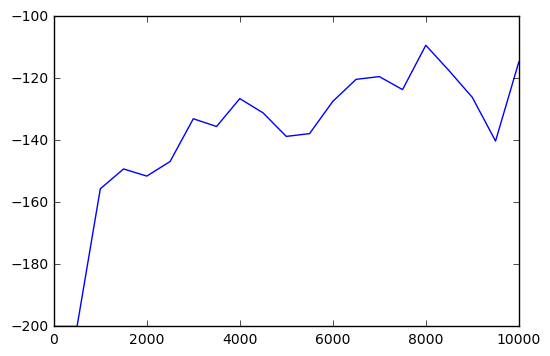

In [24]:
plt.plot(iters,map(np.mean,session_rewards))

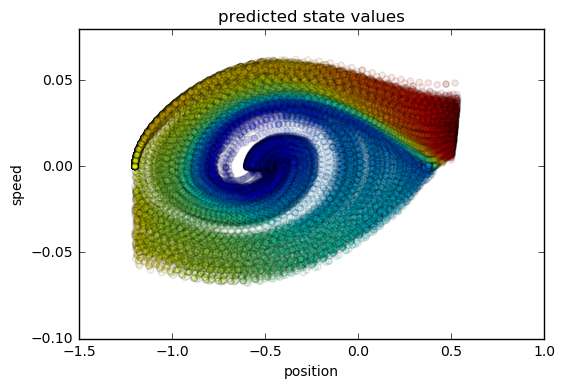

In [32]:

_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

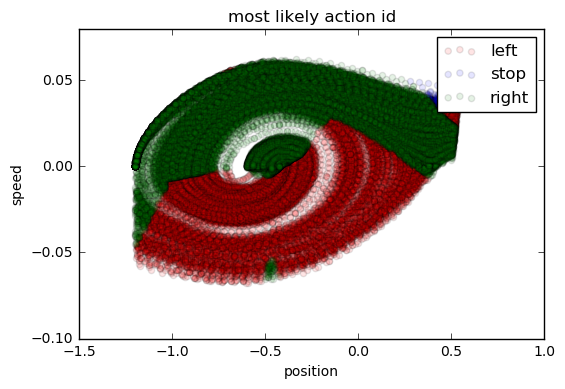

In [45]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()

for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')